<a href="https://colab.research.google.com/github/Cyberstrings/rfiles/blob/main/Copy_of_645proj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from shapely.geometry import shape, Point
from shapely.wkt import loads
import geopandas as gpd
import warnings
import folium
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

transacs = pd.read_csv('transactions.csv')
stations = pd.read_csv('bus_stations_downtown.csv')

In [ ]:
transacs

,Card code,Boarding time,Time of getting off,The route of boarding,On station,The route of getting off,Off station,Sign
0,53326844,2019-09-01 06:30,2019-09-01 06:49,13,3,13,11,Bl
1,29105554,2019-09-01 14:54,2019-09-01 16:35,6,26,6,20,B3
2,53825579,2019-09-01 16:27,2019-09-01 17:30,6,26,6,13,B3
3,93547609,2019-09-01 07:29,2019-09-01 07:40,13,17,13,7,B3
4,68546381,2019-09-01 15:56,2019-09-01 17:01,6,21,6,3,B3
...,...,...,...,...,...,...,...,...
1495,34362924,2019-09-01 09:56,2019-09-01 11:22,7,8,7,5,B3
1496,97353185,2019-09-01 09:08,2019-09-01 10:15,6,21,6,18,B3
1497,75766924,2019-09-01 13:44,2019-09-01 14:06,6,16,6,24,Bl
1498,59782471,2019-09-01 13:40,2019-09-01 15:14,13,9,13,16,Bl


In [ ]:
stations

,ROUTE_SHOR,TELERIDE_N,STOP_NAME,ROUTE_LONG,X,Y
0,6,7943,WB 17 AV SW @ 16A ST SW,Killarney/26 Av SW,-114.100385,51.037885
1,7,5146,EB 5 AV SW @ 8 ST SW,Marda Loop,-114.080211,51.048779
2,7,5385,EB 5 AV SW @ 1 ST SW,Marda Loop,-114.065894,51.048393
3,7,5332,SB 14 ST SW@ 21 AV SW,Marda Loop,-114.094778,51.035155
4,7,8089,EB 12 AV SW @ 12 ST SW,Marda Loop,-114.090959,51.042130
...,...,...,...,...,...,...
63,6,8665,WB 11 AV @ 10 ST SW,Killarney/26 Av SW,-114.087587,51.043125
64,7,5331,SB 14 ST SW@ 17 AV SW,Marda Loop,-114.094876,51.037451
65,13,7337,SB 1 ST SW @ 8 AV SW,Altadore,-114.065559,51.045750
66,7,7840,SB 1 ST SW @ 10 AV SW,Marda Loop,-114.065776,51.043038


In [ ]:
print("The number of unique routes in transacs:\n",transacs['The route of boarding'].unique())
print("The number of unique routes in stations:\n",stations['ROUTE_SHOR'].unique())

The number of unique routes in transacs:
 [13  6  7]
The number of unique routes in stations:
 [ 6  7 13]


In [ ]:
route_stations = {}

# Iterate through the rows of the dataframe
for index, row in stations.iterrows():
    route = row['ROUTE_SHOR']
    if route not in route_stations:
        route_stations[route] = 1
    else:
        route_stations[route] = route_stations[route] + 1
    stations.at[index, 'Stop_Number'] = int(route_stations[route])

# Display the updated dataframe
display(stations)

,ROUTE_SHOR,TELERIDE_N,STOP_NAME,ROUTE_LONG,X,Y,Stop_Number
0,6,7943,WB 17 AV SW @ 16A ST SW,Killarney/26 Av SW,-114.100385,51.037885,1.0
1,7,5146,EB 5 AV SW @ 8 ST SW,Marda Loop,-114.080211,51.048779,1.0
2,7,5385,EB 5 AV SW @ 1 ST SW,Marda Loop,-114.065894,51.048393,2.0
3,7,5332,SB 14 ST SW@ 21 AV SW,Marda Loop,-114.094778,51.035155,3.0
4,7,8089,EB 12 AV SW @ 12 ST SW,Marda Loop,-114.090959,51.042130,4.0
...,...,...,...,...,...,...,...
63,6,8665,WB 11 AV @ 10 ST SW,Killarney/26 Av SW,-114.087587,51.043125,26.0
64,7,5331,SB 14 ST SW@ 17 AV SW,Marda Loop,-114.094876,51.037451,22.0
65,13,7337,SB 1 ST SW @ 8 AV SW,Altadore,-114.065559,51.045750,18.0
66,7,7840,SB 1 ST SW @ 10 AV SW,Marda Loop,-114.065776,51.043038,23.0


In [ ]:
# Filter stations dataframe for route number 6
route_6_stations = stations[stations['ROUTE_SHOR'] == 6]

# Create a map centered around Calgary
m = folium.Map(location=[51.0447, -114.0719], zoom_start=12)

# Plot route line for route number 6
route_6_points = route_6_stations[['Y', 'X']].values.tolist()

# Plot stops for route number 6
for _, station in route_6_stations.iterrows():
    folium.CircleMarker(location=[station['Y'], station['X']], radius=5, color='blue', fill=True, fill_color='blue').add_to(m)

# Display the map
m


In [ ]:
# Filter stations dataframe for route number 7
route_7_stations = stations[stations['ROUTE_SHOR'] == 7]

# Create a map centered around Calgary
m = folium.Map(location=[51.0447, -114.0719], zoom_start=12)

# Plot route line for route number 6
route_7_points = route_7_stations[['Y', 'X']].values.tolist()

# Plot stops for route number 6
for _, station in route_7_stations.iterrows():
    folium.CircleMarker(location=[station['Y'], station['X']], radius=5, color='green', fill=True, fill_color='green').add_to(m)

# Display the map
m


In [ ]:
# Filter stations dataframe for route number 13
route_13_stations = stations[stations['ROUTE_SHOR'] == 13]

# Create a map centered around Calgary
m = folium.Map(location=[51.0447, -114.0719], zoom_start=12)

# Plot route line for route number 13
route_13_points = route_13_stations[['Y', 'X']].values.tolist()

# Plot stops for route number 13
for _, station in route_13_stations.iterrows():
    folium.CircleMarker(location=[station['Y'], station['X']], radius=5, color='purple', fill=True, fill_color='purple').add_to(m)

# Display the map
m


In [ ]:
route_6_stations

,ROUTE_SHOR,TELERIDE_N,STOP_NAME,ROUTE_LONG,X,Y,Stop_Number
0,6,7943,WB 17 AV SW @ 16A ST SW,Killarney/26 Av SW,-114.100385,51.037885,1.0
6,6,8784,NB 17A ST SW @ 17 AV SW,Killarney/26 Av SW,-114.102814,51.037585,2.0
8,6,7922,EB 17 AV SW @ 9A ST SW fs,Killarney/26 Av SW,-114.085397,51.037763,3.0
12,6,5304,WB 11 AV SW@ 8 ST SW,Killarney/26 Av SW,-114.082075,51.042961,4.0
17,6,5118,WB 6 AV SW @ 2 ST SW,Killarney/26 Av SW,-114.067452,51.047676,5.0
20,6,5307,SB 17A ST SW@ 17 AV SW,Killarney/26 Av SW,-114.102994,51.037455,6.0
21,6,8771,EB 17 AV SW @ 8 ST SW,Killarney/26 Av SW,-114.081062,51.037745,7.0
22,6,5325,NB 1 ST SW @ 17 AV SW,Killarney/26 Av SW,-114.065897,51.038193,8.0
24,6,5122,SB 8 ST SW @ 7 AV SW ns,Killarney/26 Av SW,-114.081282,51.047186,9.0
30,6,5303,NB 1 ST SW @ 7 AV SW,Killarney/26 Av SW,-114.065335,51.046400,10.0


In [ ]:
def calculate_shortest_distance(station, other_stations):
    shortest_distance = float('inf')
    shortest_station_name = None
    shortest_station_number = None

    for other_station in other_stations.itertuples():
        distance = geodesic((station['Y'], station['X']), (other_station.Y, other_station.X)).meters
        if distance < shortest_distance:
            route = other_station.ROUTE_SHOR
            shortest_distance = distance
            shortest_station_name = other_station.STOP_NAME
            shortest_station_number = other_station.Stop_Number

    return route, shortest_distance, shortest_station_name, shortest_station_number

# Calculate shortest distances for route 6 stations with route 7 and route 13 stations

route_6_stations['Alt_Route_1'], route_6_stations['Nearest_AR1_Stn_Dist'], route_6_stations['Nearest_AR1_Stn_Name'], route_6_stations['Nearest_AR1_Stn_No'] = zip(*route_6_stations.apply(lambda x: calculate_shortest_distance(x, route_7_stations), axis=1))
route_6_stations['Alt_Route_2'], route_6_stations['Nearest_AR2_Stn_Dist'], route_6_stations['Nearest_AR2_Stn_Name'], route_6_stations['Nearest_AR2_Stn_No'] = zip(*route_6_stations.apply(lambda x: calculate_shortest_distance(x, route_13_stations), axis=1))
route_7_stations['Alt_Route_1'], route_7_stations['Nearest_AR1_Stn_Dist'], route_7_stations['Nearest_AR1_Stn_Name'], route_7_stations['Nearest_AR1_Stn_No'] = zip(*route_7_stations.apply(lambda x: calculate_shortest_distance(x, route_6_stations), axis=1))
route_7_stations['Alt_Route_2'], route_7_stations['Nearest_AR2_Stn_Dist'], route_7_stations['Nearest_AR2_Stn_Name'], route_7_stations['Nearest_AR2_Stn_No'] = zip(*route_7_stations.apply(lambda x: calculate_shortest_distance(x, route_13_stations), axis=1))
route_13_stations['Alt_Route_1'], route_13_stations['Nearest_AR1_Stn_Dist'], route_13_stations['Nearest_AR1_Stn_Name'], route_13_stations['Nearest_AR1_Stn_No'] = zip(*route_13_stations.apply(lambda x: calculate_shortest_distance(x, route_6_stations), axis=1))
route_13_stations['Alt_Route_2'], route_13_stations['Nearest_AR2_Stn_Dist'], route_13_stations['Nearest_AR2_Stn_Name'], route_13_stations['Nearest_AR2_Stn_No'] = zip(*route_13_stations.apply(lambda x: calculate_shortest_distance(x, route_7_stations), axis=1))

# Repeat the process for route 7 stations and route 13 stations
# Function to find the nearest station in another dataframe

display(route_6_stations)

,ROUTE_SHOR,TELERIDE_N,STOP_NAME,ROUTE_LONG,X,Y,Stop_Number,Alt_Route_1,Nearest_AR1_Stn_Dist,Nearest_AR1_Stn_Name,Nearest_AR1_Stn_No,Alt_Route_2,Nearest_AR2_Stn_Dist,Nearest_AR2_Stn_Name,Nearest_AR2_Stn_No
0,6,7943,WB 17 AV SW @ 16A ST SW,Killarney/26 Av SW,-114.100385,51.037885,1.0,7,389.357720,SB 14 ST SW@ 17 AV SW,22.0,13,1298.118941,SB 8 ST SW @ 17 AV SW,8.0
6,6,8784,NB 17A ST SW @ 17 AV SW,Killarney/26 Av SW,-114.102814,51.037585,2.0,7,556.979779,SB 14 ST SW@ 17 AV SW,22.0,13,1466.903643,SB 8 ST SW @ 17 AV SW,8.0
8,6,7922,EB 17 AV SW @ 9A ST SW fs,Killarney/26 Av SW,-114.085397,51.037763,3.0,7,122.584719,WB 17 AV SW @ 10 ST SW,6.0,13,252.687858,SB 8 ST SW @ 17 AV SW,8.0
12,6,5304,WB 11 AV SW@ 8 ST SW,Killarney/26 Av SW,-114.082075,51.042961,4.0,7,62.119898,NB 8 ST SW @ 11 AV SW,15.0,13,62.119898,NB 8 ST SW @ 11 AV SW,7.0
17,6,5118,WB 6 AV SW @ 2 ST SW,Killarney/26 Av SW,-114.067452,51.047676,5.0,7,135.229601,EB 5 AV SW @ 1 ST SW,2.0,13,105.048361,EB 5 AV @ 2 ST SW,5.0
20,6,5307,SB 17A ST SW@ 17 AV SW,Killarney/26 Av SW,-114.102994,51.037455,6.0,7,569.363912,SB 14 ST SW@ 17 AV SW,22.0,13,1479.124104,SB 8 ST SW @ 17 AV SW,8.0
21,6,8771,EB 17 AV SW @ 8 ST SW,Killarney/26 Av SW,-114.081062,51.037745,7.0,7,88.112826,WB 17 AV SW @ 8 ST SW,24.0,13,85.697270,SB 8 ST SW @ 17 AV SW,8.0
22,6,5325,NB 1 ST SW @ 17 AV SW,Killarney/26 Av SW,-114.065897,51.038193,8.0,7,58.001883,WB 17 AV SW@ 1 ST SW,5.0,13,528.938063,WB 11 AV SW @ 2 ST SW,6.0
24,6,5122,SB 8 ST SW @ 7 AV SW ns,Killarney/26 Av SW,-114.081282,51.047186,9.0,7,55.209684,NB 8 ST SW @ 7 AV SW,9.0,13,55.209684,NB 8 ST SW @ 7 AV SW,12.0
30,6,5303,NB 1 ST SW @ 7 AV SW,Killarney/26 Av SW,-114.065335,51.046400,10.0,7,99.812226,SB 1 ST @ 6 AV SW,19.0,13,74.006422,SB 1 ST SW @ 8 AV SW,18.0


In [ ]:
display(route_13_stations)

,ROUTE_SHOR,TELERIDE_N,STOP_NAME,ROUTE_LONG,X,Y,Stop_Number,Alt_Route_1,Nearest_AR1_Stn_Dist,Nearest_AR1_Stn_Name,Nearest_AR1_Stn_No,Alt_Route_2,Nearest_AR2_Stn_Dist,Nearest_AR2_Stn_Name,Nearest_AR2_Stn_No
5,13,2491,SB 1 ST @ 6 AV SW,Altadore,-114.065550,51.047287,1.0,6,99.812226,NB 1 ST SW @ 7 AV SW,10.0,7,0.000000,SB 1 ST @ 6 AV SW,19.0
9,13,4712,WB 11 AV SW @ 4 ST SW,Altadore,-114.072217,51.042714,2.0,6,471.724604,NB 1 ST SW @ 10 AV SW,22.0,7,453.177046,SB 1 ST SW @ 10 AV SW,23.0
11,13,4849,SB 8 ST SW @ 14 AV SW,Altadore,-114.081836,51.039734,3.0,6,227.854775,EB 17 AV SW @ 8 ST SW,7.0,7,206.374881,WB 17 AV SW @ 8 ST SW,24.0
15,13,4850,NB 8 ST SW @ 14 AV SW,Altadore,-114.081495,51.040391,4.0,6,288.694218,WB 11 AV SW@ 8 ST SW,4.0,7,249.972378,NB 8 ST SW @ 11 AV SW,15.0
19,13,9957,EB 5 AV @ 2 ST SW,Altadore,-114.068224,51.048485,5.0,6,105.048361,WB 6 AV SW @ 2 ST SW,5.0,7,163.729359,EB 5 AV SW @ 1 ST SW,2.0
23,13,5581,WB 11 AV SW @ 2 ST SW,Altadore,-114.068729,51.042599,6.0,6,232.745357,NB 1 ST SW @ 10 AV SW,22.0,7,212.752748,SB 1 ST SW @ 10 AV SW,23.0
27,13,5143,NB 8 ST SW @ 11 AV SW,Altadore,-114.081354,51.042637,7.0,6,62.119898,WB 11 AV SW@ 8 ST SW,4.0,7,0.000000,NB 8 ST SW @ 11 AV SW,15.0
32,13,5583,SB 8 ST SW @ 17 AV SW,Altadore,-114.081910,51.037191,8.0,6,85.697270,EB 17 AV SW @ 8 ST SW,7.0,7,83.563302,WB 17 AV SW @ 8 ST SW,24.0
36,13,5147,EB 5 AV SW @ 5 ST SW,Altadore,-114.072603,51.048597,9.0,6,164.625498,WB 6 AV SW @ 3 ST SW,25.0,7,0.000000,EB 5 AV SW @ 5 ST SW,14.0
39,13,4679,NB 8 ST SW @ 19 AV SW,Altadore,-114.081700,51.036448,10.0,6,151.102005,EB 17 AV SW @ 8 ST SW,7.0,7,167.025161,WB 17 AV SW @ 8 ST SW,24.0


In [ ]:
'''
def find_nearest_station(row, other_stations_df):
    min_distance = float('inf')
    nearest_station_name = ''
    nearest_station_number = ''

    for index, other_row in other_stations_df.iterrows():
        distance = geodesic((row['Y'], row['X']), (other_row['Y'], other_row['X'])).meters
        if distance < min_distance:
            min_distance = distance
            nearest_station_name = other_row['STOP_NAME']
            nearest_station_number = other_row['Stop_Number']

    return min_distance, nearest_station_name, nearest_station_number

# Iterate over route_6_stations and find the nearest stations in route_7_stations and route_13_stations
for index, row in route_6_stations.iterrows():
    # Find nearest station in route_7_stations
    min_distance_7, nearest_station_name_7, nearest_station_number_7 = find_nearest_station(row, route_7_stations)
    route_6_stations.at[index, 'Nearest_R7_Stn_Dist'] = min_distance_7
    route_6_stations.at[index, 'Nearest_R7_Stn_Name'] = nearest_station_name_7
    route_6_stations.at[index, 'Nearest_R7_Stn_No'] = nearest_station_number_7

    # Find nearest station in route_13_stations
    min_distance_13, nearest_station_name_13, nearest_station_number_13 = find_nearest_station(row, route_13_stations)
    route_6_stations.at[index, 'Nearest_R13_Stn_Dist'] = min_distance_13
    route_6_stations.at[index, 'Nearest_R13_Stn_Name'] = nearest_station_name_13
    route_6_stations.at[index, 'Nearest_R13_Stn_N0'] = nearest_station_number_13
'''

"\ndef find_nearest_station(row, other_stations_df):\n    min_distance = float('inf')\n    nearest_station_name = ''\n    nearest_station_number = ''\n    \n    for index, other_row in other_stations_df.iterrows():\n        distance = geodesic((row['Y'], row['X']), (other_row['Y'], other_row['X'])).meters\n        if distance < min_distance:\n            min_distance = distance\n            nearest_station_name = other_row['STOP_NAME']\n            nearest_station_number = other_row['Stop_Number']\n    \n    return min_distance, nearest_station_name, nearest_station_number\n\n# Iterate over route_6_stations and find the nearest stations in route_7_stations and route_13_stations\nfor index, row in route_6_stations.iterrows():\n    # Find nearest station in route_7_stations\n    min_distance_7, nearest_station_name_7, nearest_station_number_7 = find_nearest_station(row, route_7_stations)\n    route_6_stations.at[index, 'Nearest_R7_Stn_Dist'] = min_distance_7\n    route_6_stations.at[inde

In [ ]:
# Convert 'Boarding time' and 'Time of getting off' to datetime
transacs['Boarding time'] = pd.to_datetime(transacs['Boarding time'])
transacs['Time of getting off'] = pd.to_datetime(transacs['Time of getting off'])

# Calculate travel time
transacs['Travel time'] = transacs['Time of getting off'] - transacs['Boarding time']

# Calculate average travel time overall
average_travel_time = transacs['Travel time'].mean()

# Calculate average travel time for each route
average_travel_time_per_route = transacs.groupby('The route of boarding')['Travel time'].mean()

print("Average travel time overall:", average_travel_time)
print("Average travel time per route:")
print(average_travel_time_per_route)


Average travel time overall: 0 days 00:58:06.800000
Average travel time per route:
The route of boarding
6    0 days 00:58:56.099426386
7    0 days 00:57:33.615221987
13   0 days 00:57:46.785714285
Name: Travel time, dtype: timedelta64[ns]


In [ ]:
# Filter rows where the route of boarding is different from the route of getting off
transfers = transacs[transacs['The route of boarding'] != transacs['The route of getting off']]
print(transfers)

Empty DataFrame
Columns: [Card code, Boarding time, Time of getting off, The route of boarding, On station, The route of getting off, Off station, Sign, Travel time]
Index: []


In [ ]:
# Count the number of passengers in each route of boarding
passenger_volume = transacs['The route of boarding'].value_counts()

# Print the passenger volume for each route of boarding
print(passenger_volume)

The route of boarding
6     523
13    504
7     473
Name: count, dtype: int64


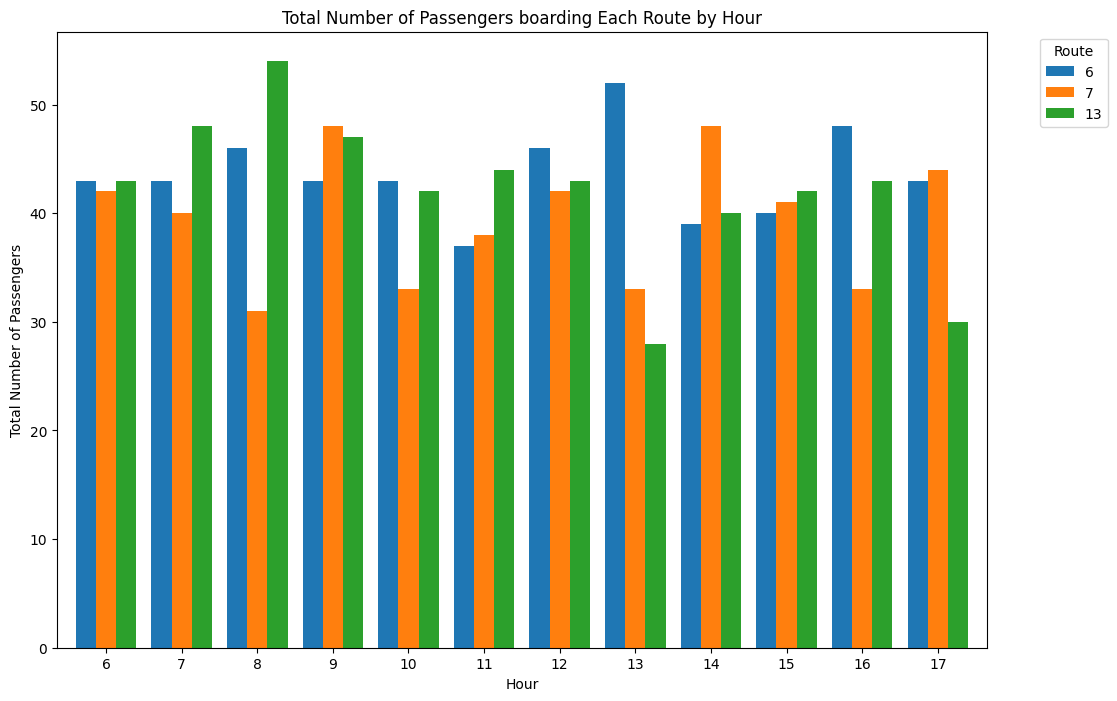

In [ ]:
# Convert 'Boarding time' column to datetime
transacs['Boarding time'] = pd.to_datetime(transacs['Boarding time'])

# Extract the hour from the 'Boarding time' column
transacs['Hour'] = transacs['Boarding time'].dt.hour

# Group by hour and route, then count the number of passengers for each group
passengers_by_hour_route = transacs.groupby(['Hour', 'The route of boarding']).size().unstack(fill_value=0)

# Plot the total number of passengers for each route over the hours
passengers_by_hour_route.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Total Number of Passengers boarding Each Route by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Number of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Route', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


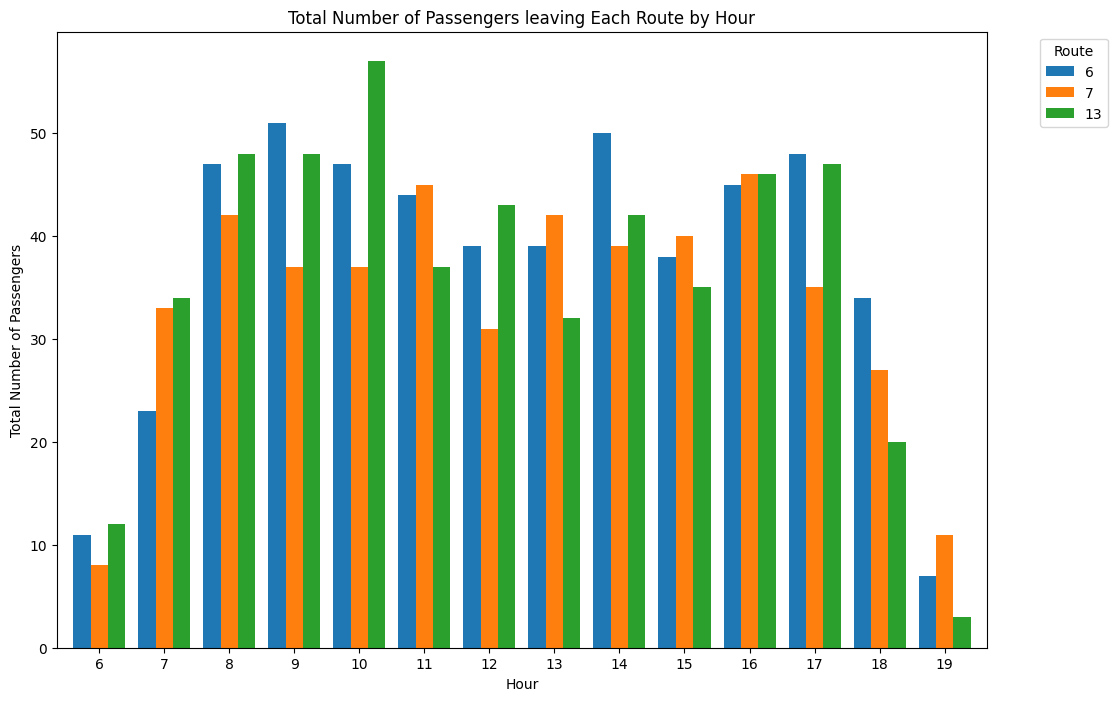

In [ ]:
# Convert 'Leaving time' column to datetime
transacs['Leaving time'] = pd.to_datetime(transacs['Time of getting off'])

# Extract the hour from the 'Leaving time' column
transacs['Hour'] = transacs['Leaving time'].dt.hour

# Group by hour and route, then count the number of passengers for each group
passengers_by_hour_route = transacs.groupby(['Hour', 'The route of getting off']).size().unstack(fill_value=0)

# Plot the total number of passengers for each route over the hours
passengers_by_hour_route.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Total Number of Passengers leaving Each Route by Hour')
plt.xlabel('Hour')
plt.ylabel('Total Number of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Route', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# Group by route and station number, then aggregate the number of passengers
boarded_passengers = transacs.groupby(['The route of boarding', 'On station']).size().reset_index(name='No of passengers boarded from here')
off_passengers = transacs.groupby(['The route of getting off', 'Off station']).size().reset_index(name='No of passengers got off here')

# Merge the two dataframes on route and station number
passenger_counts = pd.merge(boarded_passengers, off_passengers, how='outer', left_on=['The route of boarding', 'On station'], right_on=['The route of getting off', 'Off station'])

# Rename columns
passenger_counts.rename(columns={'The route of boarding': 'Route', 'On station': 'Station number'}, inplace=True)

# Fill NaN values with 0
passenger_counts.fillna(0, inplace=True)

# Convert passenger counts to integers
passenger_counts['No of passengers boarded from here'] = passenger_counts['No of passengers boarded from here'].astype(int)
passenger_counts['No of passengers got off here'] = passenger_counts['No of passengers got off here'].astype(int)

# Drop the redundant columns
passenger_counts.drop(columns=['The route of getting off', 'Off station'], inplace=True)

# Print the resulting dataframe
display(passenger_counts)


,Route,Station number,No of passengers boarded from here,No of passengers got off here
0,6,1,18,25
1,6,2,16,26
2,6,3,14,16
3,6,4,19,18
4,6,5,18,23
...,...,...,...,...
63,13,14,21,20
64,13,15,29,30
65,13,16,20,31
66,13,17,26,32


In [ ]:
# Make a route list for every passenger
# Iterate over each row in the DataFrame
for index, row in transacs.iterrows():
    # Initialize the route list with card code, the route of boarding, and the route of getting off
    route_list = [row['Card code'], row['The route of boarding'], row['The route of getting off']]

    # Add the on station
    route_list.append(row['On station'])

    # Add intermediate stations if available
    if row['On station'] < row['Off station']:
        for i in range(row['On station'] + 1, row['Off station']):
            route_list.append(i)
    elif row['On station'] > row['Off station']:
        for i in range(row['On station'] - 1, row['Off station'], -1):
            route_list.append(i)

    # Add the off station
    route_list.append(row['Off station'])

    # Print the route list
    print(route_list)


[53326844, 13, 13, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[29105554, 6, 6, 26, 25, 24, 23, 22, 21, 20]
[53825579, 6, 6, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13]
[93547609, 13, 13, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7]
[68546381, 6, 6, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
[34269112, 13, 13, 1, 2, 3, 4, 5, 6]
[59527940, 6, 6, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[17319852, 6, 6, 18, 17, 16, 15, 14, 13, 12]
[82354125, 7, 7, 5, 6]
[92819102, 13, 13, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[78157705, 7, 7, 14, 13, 12]
[71411641, 13, 13, 15, 16]
[86645157, 13, 13, 16, 15, 14, 13, 12, 11, 10, 9]
[78040323, 7, 7, 20, 21]
[31921780, 13, 13, 2, 3, 4, 5, 6, 7, 8]
[28571686, 13, 13, 5, 6, 7]
[72229494, 13, 13, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[55983246, 13, 13, 10, 9, 8, 7]
[29074590, 7, 7, 7, 6, 5, 4, 3, 2, 1]
[20365073, 13, 13, 3, 4, 5]
[38391523, 13, 13, 10, 11, 12, 13, 14, 15, 16, 17]
[64986293, 6, 6, 9, 10, 11,

In [ ]:
p1 = (51.048393, -114.065894)
p2 = (51.048779, -114.080211)
print(geodesic(p1, p2).meters)  # 23576.805481751613

1004.8881047887924


In [ ]:
# Function to calculate the distance between two points
def calculate_distance(latlon1, latlon2):
    return geodesic(latlon1, latlon2).meters

# Function to find the nearest stop on the same route
def find_nearest_stop(row, stations):
    # Filter stations dataframe for stops on the same route
    same_route_stations = stations[stations['ROUTE_SHOR'] == row['ROUTE_SHOR']]
    same_route_stations = same_route_stations[stations['TELERIDE_N'] != row['TELERIDE_N']]

    # Calculate distances to all other stops on the same route
    same_route_stations['Distance'] = same_route_stations.apply(
        lambda x: calculate_distance((row['Y'], row['X']), (x['Y'], x['X'])), axis=1)

    # Get the nearest stop
    nearest_stop = same_route_stations.loc[same_route_stations['Distance'].idxmin()]

    # Return the nearest stop name, route, and distance
    return nearest_stop['STOP_NAME'], nearest_stop['ROUTE_SHOR'], nearest_stop['Stop_Number'], nearest_stop['Distance']

# Apply the function to each row in the stations dataframe
stations['Nearest Stop Name'], stations['Nearest Stop Route'], stations['Nearest Stop Number'], stations['Distance to Nearest Stop'] = zip(*stations.apply(
    lambda row: find_nearest_stop(row, stations), axis=1))

# Display the modified dataframe
display(stations)


,ROUTE_SHOR,TELERIDE_N,STOP_NAME,ROUTE_LONG,X,Y,Stop_Number,Nearest Stop Name,Nearest Stop Route,Nearest Stop Number,Distance to Nearest Stop
0,6,7943,WB 17 AV SW @ 16A ST SW,Killarney/26 Av SW,-114.100385,51.037885,1.0,EB 17 AV SW @ 17 ST SW,6,24.0,57.036913
1,7,5146,EB 5 AV SW @ 8 ST SW,Marda Loop,-114.080211,51.048779,1.0,NB 8 ST SW @ 7 AV SW,7,9.0,238.294971
2,7,5385,EB 5 AV SW @ 1 ST SW,Marda Loop,-114.065894,51.048393,2.0,SB 1 ST @ 6 AV SW,7,19.0,125.382717
3,7,5332,SB 14 ST SW@ 21 AV SW,Marda Loop,-114.094778,51.035155,3.0,NB 14 ST SW @ 21 AV SW,7,12.0,21.400349
4,7,8089,EB 12 AV SW @ 12 ST SW,Marda Loop,-114.090959,51.042130,4.0,EB 12 AV SW @ 11 ST SW,7,21.0,183.979312
...,...,...,...,...,...,...,...,...,...,...,...
63,6,8665,WB 11 AV @ 10 ST SW,Killarney/26 Av SW,-114.087587,51.043125,26.0,WB 11 AV SW@ 8 ST SW,6,4.0,386.969922
64,7,5331,SB 14 ST SW@ 17 AV SW,Marda Loop,-114.094876,51.037451,22.0,NB 14 ST SW@ 17 AV SW,7,20.0,94.532107
65,13,7337,SB 1 ST SW @ 8 AV SW,Altadore,-114.065559,51.045750,18.0,SB 1 ST @ 6 AV SW,13,1.0,170.991084
66,7,7840,SB 1 ST SW @ 10 AV SW,Marda Loop,-114.065776,51.043038,23.0,SB 1 ST SW @ 13 AV SW ns,7,7.0,262.076375


In [ ]:
# Bar plot of passengers entering and leaving a stop at a route at various hours throughout the day

def calculate_passenger_count(route, stop, transacs):
    # Filter transactions for the given route and stop
    route_filter = transacs[(transacs['The route of boarding'] == route) &
                            (transacs['On station'] == stop)]
    route_filter_off = transacs[(transacs['The route of getting off'] == route) &
                                (transacs['Off station'] == stop)]

    # Initialize dictionaries to store passenger counts
    passengers_boarding = {}
    passengers_getting_off = {}

    # Iterate through the filtered dataframe and calculate passenger counts for each timestamp
    for index, row in route_filter.iterrows():
        boarding_time = row['Boarding time']
        passengers_boarding[boarding_time] = passengers_boarding.get(boarding_time, 0) + 1

    for index, row in route_filter_off.iterrows():
        off_time = row['Time of getting off']
        passengers_getting_off[off_time] = passengers_getting_off.get(off_time, 0) + 1

    return passengers_boarding, passengers_getting_off

# Example usage
route = 6
stop = 1
passengers_boarding, passengers_getting_off = calculate_passenger_count(route, stop, transacs)

# Convert passengers_boarding dictionary to a dataframe
boarding_df = pd.DataFrame(list(sorted(passengers_boarding.items())), columns=['Boarding Time', 'Passenger Count'])
leaving_df = pd.DataFrame(list(sorted(passengers_getting_off.items())), columns=['Leaving Time', 'Passenger Count'])

# Sort the dataframe by time
boarding_df.sort_values(by='Boarding Time', inplace=True)
leaving_df.sort_values(by='Leaving Time', inplace=True)

print("Passengers boarding at stop",stop, "of route:",route)
display(boarding_df)
print(f"\nPassengers getting off at stop {stop} of route {route}:")
display(leaving_df)


Passengers boarding at stop 1 of route: 6


,Boarding Time,Passenger Count
0,2019-09-01 06:13:00,1
1,2019-09-01 06:45:00,1
2,2019-09-01 07:21:00,1
3,2019-09-01 07:56:00,1
4,2019-09-01 08:04:00,1
5,2019-09-01 08:24:00,1
6,2019-09-01 11:38:00,1
7,2019-09-01 11:55:00,1
8,2019-09-01 12:14:00,1
9,2019-09-01 13:27:00,1



Passengers getting off at stop 1 of route 6:


,Leaving Time,Passenger Count
0,2019-09-01 09:16:00,1
1,2019-09-01 09:53:00,1
2,2019-09-01 10:02:00,1
3,2019-09-01 10:24:00,1
4,2019-09-01 10:39:00,1
5,2019-09-01 11:00:00,1
6,2019-09-01 11:27:00,1
7,2019-09-01 11:40:00,1
8,2019-09-01 12:20:00,1
9,2019-09-01 12:53:00,1


In [ ]:
# Example usage
route = 6
stop = 2
passengers_boarding, passengers_getting_off = calculate_passenger_count(route, stop, transacs)

# Convert passengers_boarding dictionary to a dataframe
boarding_df = pd.DataFrame(list(sorted(passengers_boarding.items())), columns=['Boarding Time', 'Passenger Count'])
leaving_df = pd.DataFrame(list(sorted(passengers_getting_off.items())), columns=['Leaving Time', 'Passenger Count'])

# Sort the dataframe by time
boarding_df.sort_values(by='Boarding Time', inplace=True)
leaving_df.sort_values(by='Leaving Time', inplace=True)

print("Passengers boarding at stop",stop, "of route:",route)
display(boarding_df)
print(f"\nPassengers getting off at stop {stop} of route {route}:")
display(leaving_df)

Passengers boarding at stop 2 of route: 6


,Boarding Time,Passenger Count
0,2019-09-01 06:23:00,1
1,2019-09-01 06:37:00,1
2,2019-09-01 08:11:00,1
3,2019-09-01 09:21:00,1
4,2019-09-01 09:40:00,1
5,2019-09-01 10:50:00,1
6,2019-09-01 11:22:00,1
7,2019-09-01 11:28:00,1
8,2019-09-01 12:09:00,2
9,2019-09-01 12:17:00,1



Passengers getting off at stop 2 of route 6:


,Leaving Time,Passenger Count
0,2019-09-01 06:49:00,1
1,2019-09-01 07:08:00,1
2,2019-09-01 07:32:00,1
3,2019-09-01 07:56:00,1
4,2019-09-01 08:25:00,1
5,2019-09-01 09:35:00,1
6,2019-09-01 09:42:00,1
7,2019-09-01 10:02:00,1
8,2019-09-01 10:40:00,1
9,2019-09-01 11:19:00,1


In [ ]:
avg_walk_speed = 1.5 #Meters per second

def remove_stations(route, station):

    new_wait_time = 0
    station_row = stations[(stations['ROUTE_SHOR'] == route) & (stations['Stop_Number'] == station)]
    '''nearest_stop_name = station_row['Nearest Stop Name']
    nearest_stop_rout = station_row['Nearest Stop Route']
    nearest_stop_numb = station_row['Nearest Stop Number']
    nearest_stop_dist = station_row['Distance to Nearest Stop']'''
    print("The following will be removed")
    print(station_row.iloc[0])
    print("---")
    print("Assuming normal walking speed is 1.5 meters per second")
    print("Time taken to reach next station:",station_row.iloc[0][10]/avg_walk_speed,"seconds")

route = int(input("Enter the route whose stop is to be removed: "))
stopno = int(input("Enter the stop number to be removed in route: "))
remove_stations(route, stopno)
#remove_stations(7, 4)

Enter the route whose stop is to be removed: 7
Enter the stop number to be removed in route: 2
The following will be removed
ROUTE_SHOR                                     7
TELERIDE_N                                  5385
STOP_NAME                   EB 5 AV SW @ 1 ST SW
ROUTE_LONG                            Marda Loop
X                                    -114.065894
Y                                      51.048393
Stop_Number                                  2.0
Nearest Stop Name              SB 1 ST @ 6 AV SW
Nearest Stop Route                             7
Nearest Stop Number                         19.0
Distance to Nearest Stop              125.382717
Name: 2, dtype: object
---
Assuming normal walking speed is 1.5 meters per second
Time taken to reach next station: 83.58847792110362 seconds


In [ ]:
# Function to find the nearest station in route 7 and route 13
def find_nearest_stations(route_6_station, route_7_stations, route_13_stations):
    min_distance_r7 = float('inf')
    nearest_station_r7 = ''
    min_distance_r13 = float('inf')
    nearest_station_r13 = ''

    for index, row in route_7_stations.iterrows():
        distance = geodesic((route_6_station['Y'], route_6_station['X']), (row['Y'], row['X'])).meters
        if distance < min_distance_r7:
            min_distance_r7 = distance
            nearest_station_r7 = row['STOP_NAME']

    for index, row in route_13_stations.iterrows():
        distance = geodesic((route_6_station['Y'], route_6_station['X']), (row['Y'], row['X'])).meters
        if distance < min_distance_r13:
            min_distance_r13 = distance
            nearest_station_r13 = row['STOP_NAME']

    return min_distance_r7, min_distance_r13, nearest_station_r7, nearest_station_r13

# User inputs
route_cancelled = int(input("Enter the route number which has been cancelled: "))
start_station = int(input("Enter the starting station: "))
end_station = int(input("Enter the destination station: "))

if route_cancelled == 6:
    start_station_row = route_6_stations[route_6_stations['Stop_Number'] == start_station].iloc[0]
    end_station_row = route_6_stations[route_6_stations['Stop_Number'] == end_station].iloc[0]

    # Find nearest stations in route 7 and route 13 for starting and ending stations
    start_min_distance_r7, start_min_distance_r13, start_nearest_station_r7, start_nearest_station_r13 = find_nearest_stations(start_station_row, route_7_stations, route_13_stations)
    end_min_distance_r7, end_min_distance_r13, end_nearest_station_r7, end_nearest_station_r13 = find_nearest_stations(end_station_row, route_7_stations, route_13_stations)

    total_distance_r7 = start_min_distance_r7 + end_min_distance_r7
    total_distance_r13 = start_min_distance_r13 + end_min_distance_r13

    if total_distance_r7 < total_distance_r13:
        print("Recommendation: Take Route 7")
        print("Total Distance (Route 7):", total_distance_r7, "meters")
        print("Nearest Route 7 Station (Start):", start_nearest_station_r7)
        print("Nearest Route 7 Station (End):", end_nearest_station_r7)
    else:
        print("Recommendation: Take Route 13")
        print("Total Distance (Route 13):", total_distance_r13, "meters")
        print("Nearest Route 13 Station (Start):", start_nearest_station_r13)
        print("Nearest Route 13 Station (End):", end_nearest_station_r13)

elif route_cancelled == 7:
    start_station_row = route_7_stations[route_7_stations['Stop_Number'] == start_station].iloc[0]
    end_station_row = route_7_stations[route_7_stations['Stop_Number'] == end_station].iloc[0]

    # Find nearest stations in route 7 and route 13 for starting and ending stations
    start_min_distance_r6, start_min_distance_r13, start_nearest_station_r6, start_nearest_station_r13 = find_nearest_stations(start_station_row, route_6_stations, route_13_stations)
    end_min_distance_r6, end_min_distance_r13, end_nearest_station_r6, end_nearest_station_r13 = find_nearest_stations(end_station_row, route_6_stations, route_13_stations)

    total_distance_r6 = start_min_distance_r6 + end_min_distance_r6
    total_distance_r13 = start_min_distance_r13 + end_min_distance_r13

    if total_distance_r6 < total_distance_r13:
        print("Recommendation: Take Route 6")
        print("Total Distance (Route 6):", total_distance_r6, "meters")
        print("Nearest Route 6 Station (Start):", start_nearest_station_r6)
        print("Nearest Route 6 Station (End):", end_nearest_station_r6)
    else:
        print("Recommendation: Take Route 13")
        print("Total Distance (Route 13):", total_distance_r13, "meters")
        print("Nearest Route 13 Station (Start):", start_nearest_station_r13)
        print("Nearest Route 13 Station (End):", end_nearest_station_r13)

elif route_cancelled == 13:
    start_station_row = route_13_stations[route_13_stations['Stop_Number'] == start_station].iloc[0]
    end_station_row = route_13_stations[route_13_stations['Stop_Number'] == end_station].iloc[0]

    # Find nearest stations in route 7 and route 13 for starting and ending stations
    start_min_distance_r6, start_min_distance_r7, start_nearest_station_r6, start_nearest_station_r7 = find_nearest_stations(start_station_row, route_6_stations, route_7_stations)
    end_min_distance_r6, end_min_distance_r7, end_nearest_station_r6, end_nearest_station_r7 = find_nearest_stations(end_station_row, route_6_stations, route_7_stations)

    total_distance_r6 = start_min_distance_r6 + end_min_distance_r6
    total_distance_r7 = start_min_distance_r7 + end_min_distance_r7

    if total_distance_r6 < total_distance_r7:
        print("Recommendation: Take Route 6")
        print("Total Distance (Route 6):", total_distance_r6, "meters")
        print("Nearest Route 6 Station (Start):", start_nearest_station_r6)
        print("Nearest Route 6 Station (End):", end_nearest_station_r6)
    else:
        print("Recommendation: Take Route 7")
        print("Total Distance (Route 7):", total_distance_r7, "meters")
        print("Nearest Route 7 Station (Start):", start_nearest_station_r7)
        print("Nearest Route 7 Station (End):", end_nearest_station_r7)

else:
    print("Invaldid route")

Enter the route number which has been cancelled: 7
Enter the starting station: 4
Enter the destination station: 8
Recommendation: Take Route 6
Total Distance (Route 6): 395.9810823113813 meters
Nearest Route 6 Station (Start): WB 11 AV @ 10 ST SW
Nearest Route 6 Station (End): WB 6 AV SW @ 6 ST SW


In [ ]:
route_rem = int(input("Enter route to be removed: "))

# Extract only route 6 from passenger_counts
route_6_passenger_counts = passenger_counts[passenger_counts['Route'] == route_rem].copy()

# Select the required columns from route_6_stations
selected_columns = ['ROUTE_SHOR', 'STOP_NAME', 'ROUTE_LONG', 'X', 'Y', 'Stop_Number',
                    'Nearest_AR1_Stn_Dist', 'Nearest_AR1_Stn_Name', 'Nearest_AR1_Stn_No',
                    'Nearest_AR2_Stn_Dist', 'Nearest_AR2_Stn_Name', 'Nearest_AR2_Stn_No']

# Create a new dataframe with selected columns
if route_rem == 6:
    route_6_shortest_stations = route_6_stations[selected_columns].copy()
elif route_rem == 7:
    route_6_shortest_stations = route_7_stations[selected_columns].copy()
elif route_rem == 13:
    route_6_shortest_stations = route_13_stations[selected_columns].copy()
else:
    print("Invalid route")

# Replace NaN values in distances with infinity for comparison
route_6_shortest_stations.fillna(float('inf'), inplace=True)

# Get the minimum distance and corresponding columns for each row
min_distances = route_6_shortest_stations[['Nearest_AR1_Stn_Dist', 'Nearest_AR2_Stn_Dist']].min(axis=1)
min_indices = route_6_shortest_stations[['Nearest_AR1_Stn_Dist', 'Nearest_AR2_Stn_Dist']].idxmin(axis=1)

# Replace the distance columns with the minimum distance and related columns
route_6_shortest_stations['Nearest_Stn_Dist'] = min_distances
#route_6_shortest_stations['Nearest_Stn_Dist'] = min_indices.apply(lambda x: x.replace('_Dist', '_Name'))

# Drop the redundant columns
route_6_shortest_stations.drop(columns=['Nearest_AR1_Stn_Dist', 'Nearest_AR1_Stn_Name', 'Nearest_AR1_Stn_No',
                                        'Nearest_AR2_Stn_Dist', 'Nearest_AR2_Stn_Name', 'Nearest_AR2_Stn_No'],
                                inplace=True)

Enter route to be removed: 7


In [ ]:
# Display the new dataframe
route_6_shortest_stations.reset_index(drop=True, inplace=True)
display(route_6_shortest_stations)


,ROUTE_SHOR,STOP_NAME,ROUTE_LONG,X,Y,Stop_Number,Nearest_Stn_Dist
0,7,EB 5 AV SW @ 8 ST SW,Marda Loop,-114.080211,51.048779,1.0,0.000000
1,7,EB 5 AV SW @ 1 ST SW,Marda Loop,-114.065894,51.048393,2.0,125.382717
2,7,SB 14 ST SW@ 21 AV SW,Marda Loop,-114.094778,51.035155,3.0,292.457367
3,7,EB 12 AV SW @ 12 ST SW,Marda Loop,-114.090959,51.042130,4.0,261.170441
4,7,WB 17 AV SW@ 1 ST SW,Marda Loop,-114.066586,51.037904,5.0,58.001883
5,7,WB 17 AV SW @ 10 ST SW,Marda Loop,-114.087130,51.037906,6.0,122.584719
6,7,SB 1 ST SW @ 13 AV SW ns,Marda Loop,-114.065944,51.040684,7.0,37.037407
7,7,EB 5 AV SW @ 6 ST SW,Marda Loop,-114.075524,51.048661,8.0,134.810641
8,7,NB 8 ST SW @ 7 AV SW,Marda Loop,-114.081076,51.046707,9.0,0.000000
9,7,EB 12 AV SW@ 14 ST SW,Marda Loop,-114.094249,51.042230,10.0,50.489252


In [ ]:
# Display the extracted dataframe
route_6_passenger_counts.reset_index(drop=True, inplace=True)
display(route_6_passenger_counts)

,Route,Station number,No of passengers boarded from here,No of passengers got off here
0,7,1,20,25
1,7,2,17,26
2,7,3,29,29
3,7,4,11,24
4,7,5,18,13
5,7,6,17,22
6,7,7,24,17
7,7,8,17,19
8,7,9,12,11
9,7,10,30,24


In [ ]:
# Multiply Shortest_Dist with No of passengers boarded from here rowwise
weighted_avg_dist_1 = route_6_shortest_stations['Nearest_Stn_Dist'] * route_6_passenger_counts['No of passengers boarded from here']

#print(weighted_avg_dist_1)
#route_6_shortest_stations['Shortest_Dist']
#route_6_passenger_counts['No of passengers boarded from here']

# Divide by the sum of No of passengers boarded from here to calculate weighted average dist
weighted_avg_dist = weighted_avg_dist_1.sum() / route_6_passenger_counts['No of passengers boarded from here'].sum()
print("Average increase in distance (m) if route is cancelled:", weighted_avg_dist)
print("Considering average walking speed (m/s):",avg_walk_speed)
print("Average increase in waiting time (in seconds) for boarding if route is cancelled:", weighted_avg_dist/avg_walk_speed)

Average increase in distance (m) if route is cancelled: 89.66593521950522
Considering average walking speed (m/s): 1.5
Average increase in waiting time (in seconds) for boarding if route is cancelled: 59.77729014633681


In [ ]:
weighted_avg_dist_1 = route_6_shortest_stations['Nearest_Stn_Dist'] * route_6_passenger_counts['No of passengers got off here']

avg_bus_speed = 10

# Divide by the sum of No of passengers boarded from here to calculate weighted average dist
weighted_avg_dist = weighted_avg_dist_1.sum() / route_6_passenger_counts['No of passengers got off here'].sum()
print("Average increase in distance (m) if route is cancelled:", weighted_avg_dist)
print("Considering average bus speed (m/s) in downtown:",avg_bus_speed)
print("Average increase in waiting time (in seconds) for getting off if route is cancelled:", weighted_avg_dist/avg_bus_speed)

Average increase in distance (m) if route is cancelled: 95.40025571464291
Considering average bus speed (m/s) in downtown: 10
Average increase in waiting time (in seconds) for getting off if route is cancelled: 9.540025571464291
